<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

#  Análise de Dados: OLAP SYSTEMS - TELEGRAM - AWS
10 de Junho de 2024.<br>
Professor: [André Perez](https://www.linkedin.com/in/andremarcosperez/)<br>
Aluno: [Raul Lemelle](https://www.linkedin.com/in/raul-lemelle)

---


## 1\. Contexto

O OLAP (Processamento Analítico Online) é uma tecnologia usada para organizar grandes bancos de dados empresariais e dar suporte ao business intelligence.

Neste projeto, realizamos a leitura dos dados gerados por um grupo no aplicativo Telegram, com o objetivo de gerar métricas que auxiliem na tomada de decisões e na avaliação das atividades deste canal de negócios.

### **1.1. Arquitetura da nossa Pipeline:**

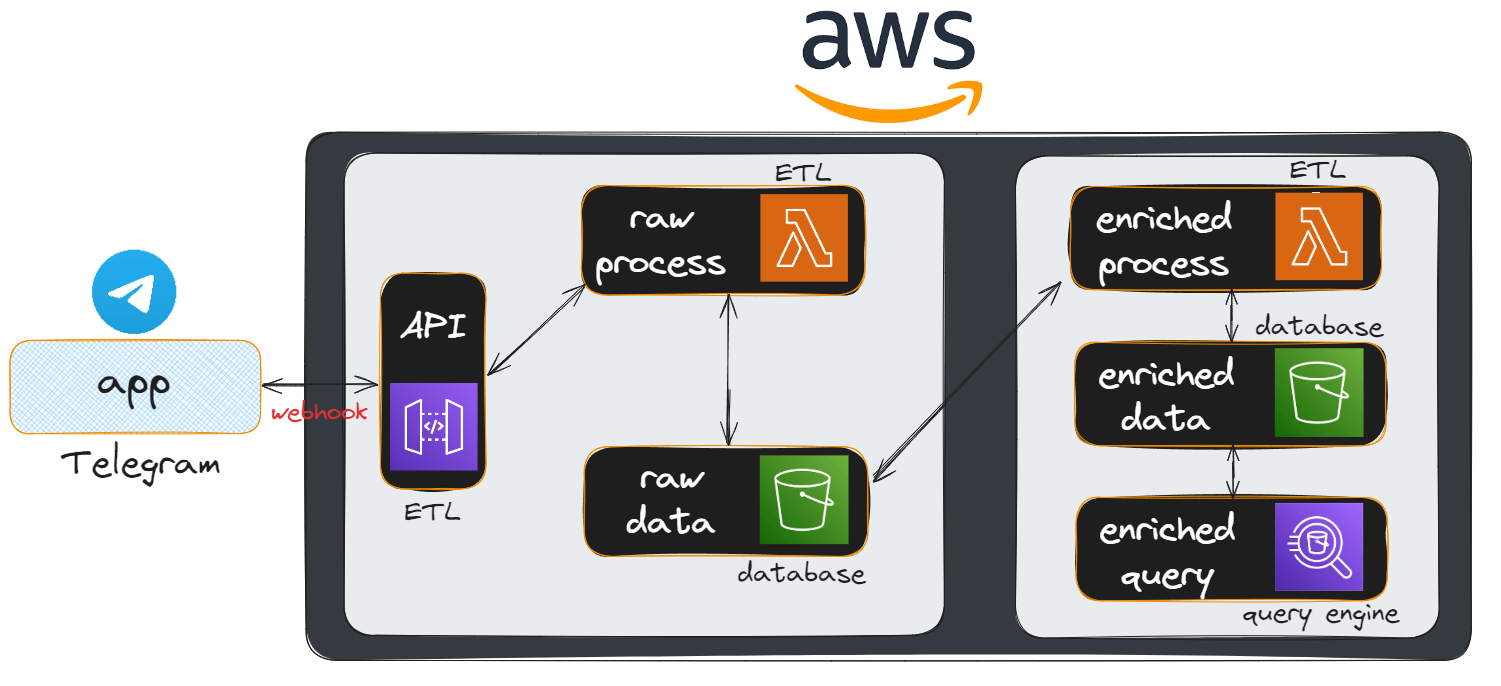

### **1.2. TLDR**

O desenvolvimento do projeto envolve a coleta e processamento de dados atualizados por meio de uma API no ambiente cloud da AWS, utilizando uma linguagem de programação como Python.

A etapa final consiste em estabelecer uma base de dados consistente para representar de forma clara diversas métricas relativas aos dados que trafegam no grupo do Telegram.

A atualização automática dos dados, juntamente com testes extensivos e a incorporação de recursos adicionais, como filtros avançados, contribuem significativamente para a robustez e utilidade do banco de dados na geração de visualizações, como um dashboard interativo.

Após o desenvolvimento, as informações resultantes agregarão valor na tomada de decisões operacionais e de negócios.

### **1.3. Dados**


Os dados são gerado através da conversa dos integrantes do grupo do aplicativo Telegram.

As mensagens captadas por um *bot* podem ser acessadas via API. A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do *bot*.

Criação do *bot* do Telegram:

Para criação do *bot* é necessário instalar e realizar as etapas de cadastro pelo smartphone. Assim feito, é necessário fazer login na versão web da ferramenta através desse [link](https://web.telegram.org).

A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api).


Passo a passo no Telegram:

1 - Na barra de pesquisa ("Search"), digitar "BotFather" e entrar na conversa.

2 - Digitar o comando "/newbot" e seguir as orientações.

3 - Criar um grupo e add o *bot* criado, e admitir o *bot* como admin do grupo.

4 - PS: Desabilitar a opção de adicionar o *bot* a novos grupos. Assim garantir que ficará somente no grupo que criamos.
Através do "BotFather" que obtemos a chave Token para obter os dados do grupo.

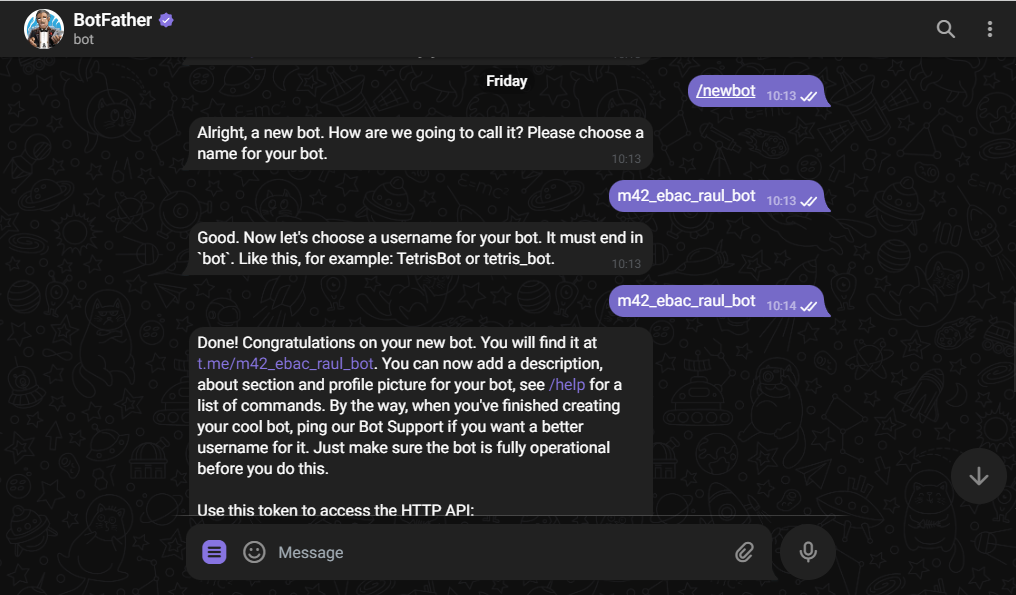

In [ ]:
# Escreve o token sem mostrar em nosso ambiente de código.
from getpass import getpass

token = getpass()

In [2]:
# A url base é comum a todos os métodos da API.
import json

base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
# O método getMe retorna informações sobre o bot.
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

In [ ]:
# O método getMe retorna as mensagens captadas pelo bot.
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

## 2\. Cloud AWS

### **2.1. INGESTÃO de dados.**

A etapa de **ingestão** é responsável, como seu o próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (*schema*). Como exemplo, dados de uma API *web* que segue o formato REST (*representational state transfer*) são entregues, logo, persistidos, no formato JSON.

Neste projeto, as mensagens capturadas pelo *bot* podem ser ingeridas através da API web de bots do Telegram, portanto são fornecidos no formato JSON. Como o Telegram retem mensagens por apenas 24h em seus servidores, a ingestão via streaming é a mais indicada. Para que seja possível esse tipo de ingestão, vamos utilizar um webhook (gancho web), ou seja, vamos redirecionar as mensagens automaticamente para outra API web.

Sendo assim, precisamos de um serviço da AWS que forneça um API *web* para receber os dados redirecionados, o `AWS API Gateway` (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). Dentre suas diversas funcionalidades, o `AWS API Gateway` permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conecta-lo ao `AWS Lambda`, que pode sua vez, irá armazenar o dado em seu formato original (JSON) em um *bucket* do `AWS S3`.

Na etapa de **ingestão**, o `AWS S3` tem a função de passivamente armazenar as mensagens captadas pelo *bot* do **Telegram** no seu formato original: JSON. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-raw` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

### **2.1. AWS Lambda.**

`AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo *bot* do **Telegram** em um *bucket* do `AWS S3`. Para tanto vamos criar uma função que opera da seguinte forma:

 - Recebe a mensagem no parâmetro `event`;
 - Verifica se a mensagem tem origem no grupo do **Telegram** correto;
 - Persiste a mensagem no formato JSON no *bucket* do `AWS S3`;
 - Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de *bots* do **Telegram**.

Código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

- Variáveis de Ambiente

Note que o código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` com o nome do *bucket* do `AWS S3` e `TELEGRAM_CHAT_ID` com o id do *chat* do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

- Permisão

Por fim, precisamos adicionar a permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

### **2.2. AWS API Gateway.**

`AWS API Gateway` tem a função de receber as mensagens captadas pelo *bot* do **Telegram**, enviadas via *webhook*, e iniciar uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro *event*. Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda`:

- Acesse o serviço e selecione: *Create API* -> *REST API*;
- Insira um nome, como padrão, um que termine com o sufixo `-api`;
- Selecione: *Actions* -> *Create Method* -> *POST*;
- Na tela de *setup*:
  - Selecione *Integration type* igual a *Lambda Function*;
  - Habilite o *Use Lambda Proxy integration*;
  - Busque pelo nome a função do `AWS Lambda`.

## 3\. Fase de TRANSFOMAÇÃO dos dados

Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de data wrangling onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de data wrangling.

Para isso, vamos utilizar uma função do `AWS Lambda` como motor de processamento e um *bucket* do `AWS S3` como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diáro da função.

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-enriched` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

### **3.1. AWS Lambda.**

`AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:

 - Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
  - Executa uma função de *data wrangling*;
  - Cria uma tabela do PyArrow e a contatena com as demais.
 - Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

PS: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

A função processa as mensagens do dia anterior (D-1).

Código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de data wrangling:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

- Variáveis de Ambiente

O código exige a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` com os nomes dos *bucket* do `AWS S3` da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do `AWS Lambda`, basta acessar configurações -> variáveis de ambiente no console da função.

- Permisão

Precisamos adicionar a permissão de escrita nos *buckets* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.

- Recursos

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

- Camadas (Layers)

Por fim, o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do `AWS Lambda` possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou *layers*, onde podemos fazer o *upload* dos pacotes Python direto na plataforma ou através de um *bucket* do `AWS S3`. Vamos então seguir com a última opção, onde teremos que:

 - Criar um *bucket* no `AWS S3`;
 - Fazer o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criar *layer* e conectar na função.

### **3.1. AWS Event Brigde.**

`AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

## 4\. Fase de APRESENTAÇÃO

### **4.1. AWS Athena.**

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

- Adicionando partições

> PS: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o `AWS Athena` para que a ela esteja disponível via SQL. Para isso, use o comando SQL `MSCK REPAIR TABLE <nome-tabela>` para todas as partições (mais caro) ou `ALTER TABLE <nome-tabela> ADD PARTITION <coluna-partição> = <valor-partição>` para uma única partição (mais barato), documentação neste [link](https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html)).

```sql
MSCK REPAIR TABLE `telegram`;
```

### **4.2. Fase ANÁLITICA.**

- Quantidade de mensagens por dia.

Essa métrica permite identificar padrões diários de atividade, ajudando a entender quais dias da semana são mais ativos e podem exigir maior atenção ou recursos.

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

- Quantidade de mensagens por usuário por dia.

Ao monitorar a frequência de mensagens de cada usuário, é possível identificar os membros mais engajados e aqueles que contribuem menos. Isso pode ser útil para estratégias de retenção e engajamento, bem como para reconhecer e valorizar os usuários mais ativos.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

- Média do tamanho das mensagens por usuário por dia.

Analisar o tamanho médio das mensagens pode revelar preferências de comunicação, como se os usuários tendem a enviar mensagens curtas e frequentes ou mensagens mais longas e detalhadas. Isso pode influenciar a forma como as comunicações são estruturadas e como o conteúdo é compartilhado dentro do grupo.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

- Quantidade de mensagens por hora por dia da semana por número da semana.

Este nível de detalhamento permite identificar picos de atividade em horários específicos e como eles variam ao longo das semanas. Compreender esses padrões pode ajudar a otimizar o timing das comunicações e a planejar eventos ou anúncios para maximizar o engajamento.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```